# Hypothesis Testing Framework for Music Recommendation System

## Objectives

This notebook conducts statistical hypothesis testing to validate key assumptions and relationships in our music recommendation system. We'll test several critical hypotheses that will inform our recommendation algorithm design.

## Key Research Questions

### 1. **Genre-Based Audio Feature Differences**
- **H₀**: Audio features (energy, danceability, valence) are the same across genres
- **H₁**: Audio features differ significantly between genres
- **Purpose**: Validate genre-based content filtering

### 2. **Popularity vs. Audio Features**
- **H₀**: Popular songs have the same audio characteristics as less popular songs
- **H₁**: Popular songs have different audio characteristics
- **Purpose**: Understand popularity bias in recommendations

### 3. **Audio Feature Correlations**
- **H₀**: No significant correlation between audio features
- **H₁**: Significant correlations exist between audio features
- **Purpose**: Feature selection and dimensionality reduction

### 4. **Temporal Patterns**
- **H₀**: Audio feature distributions are consistent over time
- **H₁**: Audio feature preferences change over time
- **Purpose**: Temporal bias detection

### 5. **Content-Based Similarity Assumptions**
- **H₀**: Songs with similar audio features receive similar ratings/preferences
- **H₁**: Audio feature similarity doesn't correlate with user preferences
- **Purpose**: Validate content-based filtering approach

---

In [42]:
# Hypothesis Testing for Music Recommendation System
# Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (
    ttest_ind, mannwhitneyu, chi2_contingency, 
    kruskal, f_oneway, pearsonr, spearmanr,
    shapiro, levene, normaltest
)

# Add these scikit-learn imports for the Content-Based Similarity test
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

In [43]:
# Load the Spotify Dataset
DATASET_PATH = "../data/processed/spotify_tracks.csv"
results_folder = "../results"
df = pd.read_csv(DATASET_PATH)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display basic info
df.head()

Dataset loaded successfully!
Shape: (113999, 20)
Columns: ['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [44]:
# Data Preparation for Hypothesis Testing

# Identify audio features for testing
audio_features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness']

# Create a clean dataset for testing
test_df = df.copy()

# Basic data quality check
print("Data Quality Check:")
print(f"Missing values: {test_df[audio_features].isnull().sum().sum()}")
print(f"Dataset shape: {test_df.shape}")

# Display audio feature statistics
print("\nAudio Feature Statistics:")
test_df[audio_features].describe()

Data Quality Check:
Missing values: 0
Dataset shape: (113999, 20)

Audio Feature Statistics:


,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,loudness
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,0.566801,0.641383,0.084652,0.314907,0.156051,0.213554,0.474066,122.147695,-8.258950
std,0.173543,0.251530,0.105733,0.332522,0.309556,0.190378,0.259261,29.978290,5.029357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-49.531000
25%,0.456000,0.472000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218500,-10.013000
50%,0.580000,0.685000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,-7.004000
75%,0.695000,0.854000,0.084500,0.597500,0.049000,0.273000,0.683000,140.071000,-5.003000
max,0.985000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,4.532000


In [45]:
# Hypothesis Test 1: Genre-Based Audio Feature Differences
# H₀: Audio features are the same across genres
# H₁: Audio features differ significantly between genres

print("=" * 60)
print("HYPOTHESIS TEST 1: GENRE-BASED AUDIO FEATURE DIFFERENCES")
print("=" * 60)

# Identify genre columns (assuming they are binary encoded)
genre_columns = [col for col in df.columns if col not in audio_features + 
                ['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'year']]

print(f"Found {len(genre_columns)} genre columns: {genre_columns[:5]}...")

# Get the main genres for each track (assuming one-hot encoding)
def get_primary_genre(row):
    """Get the primary genre for a track"""
    for genre in genre_columns:
        if row[genre] == 1:
            return genre
    return 'unknown'

# Add primary genre column
test_df['primary_genre'] = test_df[genre_columns].apply(get_primary_genre, axis=1)

# Get top 5 genres for analysis
top_genres = test_df['primary_genre'].value_counts().head(5).index.tolist()
print(f"\nTop 5 genres for testing: {top_genres}")

# Filter data for top genres
genre_test_df = test_df[test_df['primary_genre'].isin(top_genres)]
print(f"Filtered dataset size: {genre_test_df.shape[0]} tracks")

HYPOTHESIS TEST 1: GENRE-BASED AUDIO FEATURE DIFFERENCES
Found 4 genre columns: ['key', 'mode', 'time_signature', 'track_genre']...

Top 5 genres for testing: ['mode', 'unknown', 'key', 'time_signature']
Filtered dataset size: 113999 tracks

Top 5 genres for testing: ['mode', 'unknown', 'key', 'time_signature']
Filtered dataset size: 113999 tracks



ANOVA Results for Audio Features Across Genres:
--------------------------------------------------
danceability   : F=284.609, p=0.000000 ***
energy         : F=404.558, p=0.000000 ***
speechiness    : F=253.450, p=0.000000 ***
acousticness   : F=602.681, p=0.000000 ***
instrumentalness: F=179.774, p=0.000000 ***
liveness       : F=20.779, p=0.000000 ***
valence        : F=108.399, p=0.000000 ***
tempo          : F=21.992, p=0.000000 ***
loudness       : F=175.581, p=0.000000 ***

Significant genre differences found in: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness']
Number of features with significant differences: 9/9

Effect Sizes (η²):
loudness       : F=175.581, p=0.000000 ***

Significant genre differences found in: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness']
Number of features with significant differences: 9/9

Effect Sizes (η²):

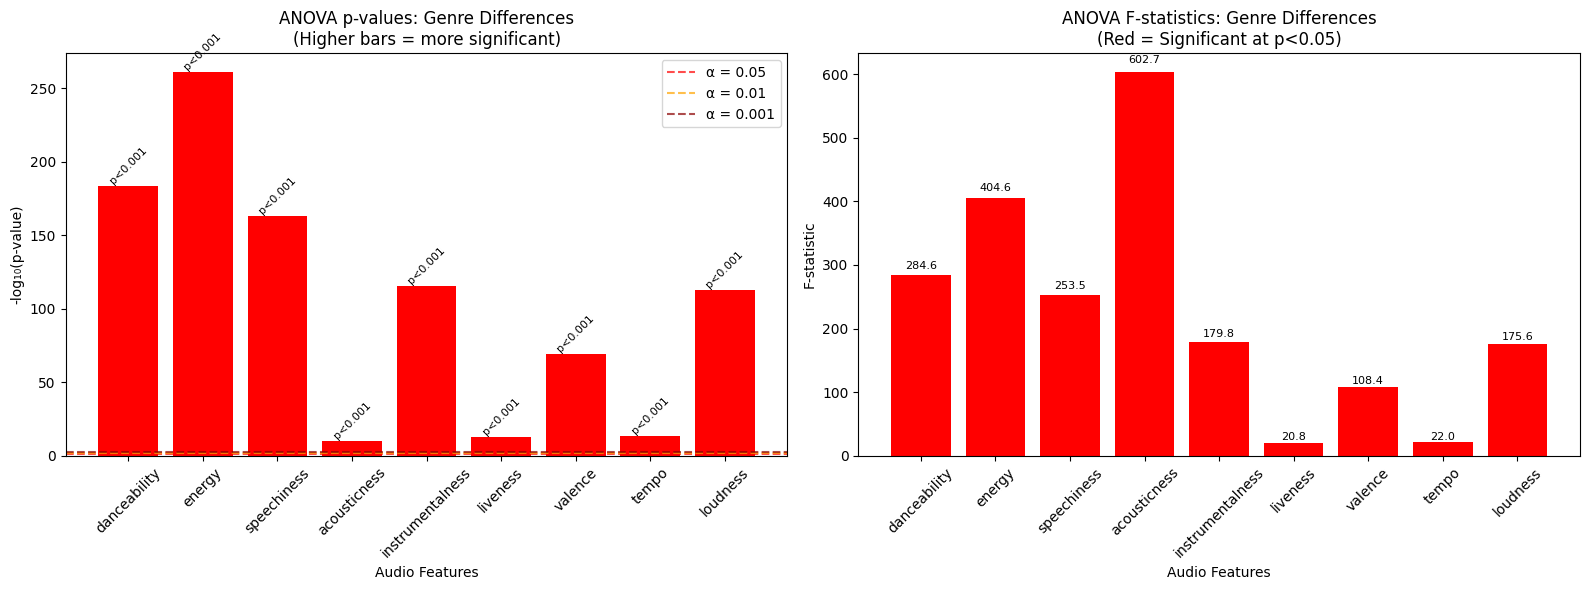

In [46]:
# Perform ANOVA tests for each audio feature across genres
print("\nANOVA Results for Audio Features Across Genres:")
print("-" * 50)

anova_results = {}
for feature in audio_features:
    # Get feature values for each genre
    genre_groups = [genre_test_df[genre_test_df['primary_genre'] == genre][feature].values 
                   for genre in top_genres]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*genre_groups)
    anova_results[feature] = {'f_statistic': f_stat, 'p_value': p_value}
    
    # Interpret results
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    print(f"{feature:15}: F={f_stat:.3f}, p={p_value:.6f} {significance}")

# Summary of significant differences
alpha = 0.05
significant_features = [feature for feature, results in anova_results.items() 
                       if results['p_value'] < alpha]

print(f"\nSignificant genre differences found in: {significant_features}")
print(f"Number of features with significant differences: {len(significant_features)}/{len(audio_features)}")

# Effect size calculation (eta-squared)
print("\nEffect Sizes (η²):")
for feature in significant_features:
    # Calculate eta-squared for significant features
    genre_groups = [genre_test_df[genre_test_df['primary_genre'] == genre][feature].values 
                   for genre in top_genres]
    
    # Total sum of squares
    overall_mean = genre_test_df[feature].mean()
    total_ss = np.sum((genre_test_df[feature] - overall_mean) ** 2)
    
    # Between group sum of squares
    between_ss = sum([len(group) * (np.mean(group) - overall_mean) ** 2 for group in genre_groups])
    
    eta_squared = between_ss / total_ss
    print(f"{feature:15}: η² = {eta_squared:.3f}")

# Create improved visualization with logarithmic scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: p-values with logarithmic scale
p_values = [anova_results[feature]['p_value'] for feature in audio_features]
colors = ['red' if p < 0.05 else 'blue' for p in p_values]

# Use -log10 transformation for p-values to make small values visible
log_p_values = [-np.log10(p) if p > 0 else 10 for p in p_values]
bars1 = ax1.bar(range(len(audio_features)), log_p_values, color=colors)

# Add significance threshold lines
ax1.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='α = 0.05')
ax1.axhline(y=-np.log10(0.01), color='orange', linestyle='--', alpha=0.7, label='α = 0.01')
ax1.axhline(y=-np.log10(0.001), color='darkred', linestyle='--', alpha=0.7, label='α = 0.001')

ax1.set_xlabel('Audio Features')
ax1.set_ylabel('-log₁₀(p-value)')
ax1.set_title('ANOVA p-values: Genre Differences\n(Higher bars = more significant)')
ax1.set_xticks(range(len(audio_features)))
ax1.set_xticklabels(audio_features, rotation=45)
ax1.legend()

# Add p-value labels on bars
for i, (bar, p_val) in enumerate(zip(bars1, p_values)):
    height = bar.get_height()
    if p_val < 0.001:
        label = 'p<0.001'
    elif p_val < 0.01:
        label = f'p={p_val:.3f}'
    else:
        label = f'p={p_val:.2f}'
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             label, ha='center', va='bottom', fontsize=8, rotation=45)

# Plot 2: F-statistics
f_stats = [anova_results[feature]['f_statistic'] for feature in audio_features]
colors2 = ['red' if anova_results[feature]['p_value'] < 0.05 else 'blue' for feature in audio_features]
bars2 = ax2.bar(range(len(audio_features)), f_stats, color=colors2)

ax2.set_xlabel('Audio Features')
ax2.set_ylabel('F-statistic')
ax2.set_title('ANOVA F-statistics: Genre Differences\n(Red = Significant at p<0.05)')
ax2.set_xticks(range(len(audio_features)))
ax2.set_xticklabels(audio_features, rotation=45)

# Add F-statistic labels on bars
for i, (bar, f_val) in enumerate(zip(bars2, f_stats)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
             f'{f_val:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(f'{results_folder}/genre_anova_results.png', dpi=300, bbox_inches='tight')
print(f"\nANOVA results visualization saved to: {results_folder}/genre_anova_results.png")
plt.show()

In [47]:
# Hypothesis Test 2: Popularity vs Audio Features
# H₀: Popular songs have the same audio characteristics as less popular songs
# H₁: Popular songs have different audio characteristics

print("\n" + "=" * 60)
print("HYPOTHESIS TEST 2: POPULARITY vs AUDIO FEATURES")
print("=" * 60)

# Define popularity threshold (e.g., top 25% are "popular")
popularity_threshold = test_df['popularity'].quantile(0.75)
print(f"Popularity threshold (75th percentile): {popularity_threshold}")

# Create popularity groups
test_df['is_popular'] = test_df['popularity'] >= popularity_threshold
popular_songs = test_df[test_df['is_popular'] == True]
non_popular_songs = test_df[test_df['is_popular'] == False]

print(f"Popular songs: {len(popular_songs)} ({len(popular_songs)/len(test_df)*100:.1f}%)")
print(f"Non-popular songs: {len(non_popular_songs)} ({len(non_popular_songs)/len(test_df)*100:.1f}%)")

# Perform t-tests for each audio feature
print("\nT-test Results for Audio Features (Popular vs Non-Popular):")
print("-" * 60)

popularity_results = {}
for feature in audio_features:
    # Get feature values for each group
    popular_values = popular_songs[feature].dropna()
    non_popular_values = non_popular_songs[feature].dropna()
    
    # Perform independent t-test
    t_stat, p_value = ttest_ind(popular_values, non_popular_values)
    
    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(popular_values) - 1) * popular_values.var() + 
                         (len(non_popular_values) - 1) * non_popular_values.var()) / 
                         (len(popular_values) + len(non_popular_values) - 2))
    cohens_d = (popular_values.mean() - non_popular_values.mean()) / pooled_std
    
    popularity_results[feature] = {
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'popular_mean': popular_values.mean(),
        'non_popular_mean': non_popular_values.mean()
    }
    
    # Interpret results
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    direction = "↑" if cohens_d > 0 else "↓"
    effect_size = "large" if abs(cohens_d) > 0.8 else "medium" if abs(cohens_d) > 0.5 else "small" if abs(cohens_d) > 0.2 else "negligible"
    
    print(f"{feature:15}: t={t_stat:6.3f}, p={p_value:.6f} {significance}, d={cohens_d:6.3f} ({effect_size}) {direction}")

# Summary of significant differences
alpha = 0.05
significant_pop_features = [feature for feature, results in popularity_results.items() 
                           if results['p_value'] < alpha]

print(f"\nSignificant popularity differences found in: {significant_pop_features}")
print(f"Number of features with significant differences: {len(significant_pop_features)}/{len(audio_features)}")

# Print means comparison for significant features
print("\nMean Comparisons for Significant Features:")
for feature in significant_pop_features:
    pop_mean = popularity_results[feature]['popular_mean']
    non_pop_mean = popularity_results[feature]['non_popular_mean']
    diff = pop_mean - non_pop_mean
    print(f"{feature:15}: Popular={pop_mean:.3f}, Non-Popular={non_pop_mean:.3f}, Diff={diff:+.3f}")


HYPOTHESIS TEST 2: POPULARITY vs AUDIO FEATURES
Popularity threshold (75th percentile): 50.0
Popular songs: 29367 (25.8%)
Non-popular songs: 84632 (74.2%)

T-test Results for Audio Features (Popular vs Non-Popular):
------------------------------------------------------------
danceability   : t=16.983, p=0.000000 ***, d= 0.115 (negligible) ↑
energy         : t=-8.331, p=0.000000 ***, d=-0.056 (negligible) ↓
speechiness    : t=-17.779, p=0.000000 ***, d=-0.120 (negligible) ↓
acousticness   : t=-11.427, p=0.000000 ***, d=-0.077 (negligible) ↓
instrumentalness: t=-26.763, p=0.000000 ***, d=-0.181 (negligible) ↓
liveness       : t=-29.538, p=0.000000 ***, d=-0.200 (small) ↓
valence        : t=-16.287, p=0.000000 ***, d=-0.110 (negligible) ↓
tempo          : t=-3.734, p=0.000188 ***, d=-0.025 (negligible) ↓
loudness       : t=11.276, p=0.000000 ***, d= 0.076 (negligible) ↑

Significant popularity differences found in: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentaln

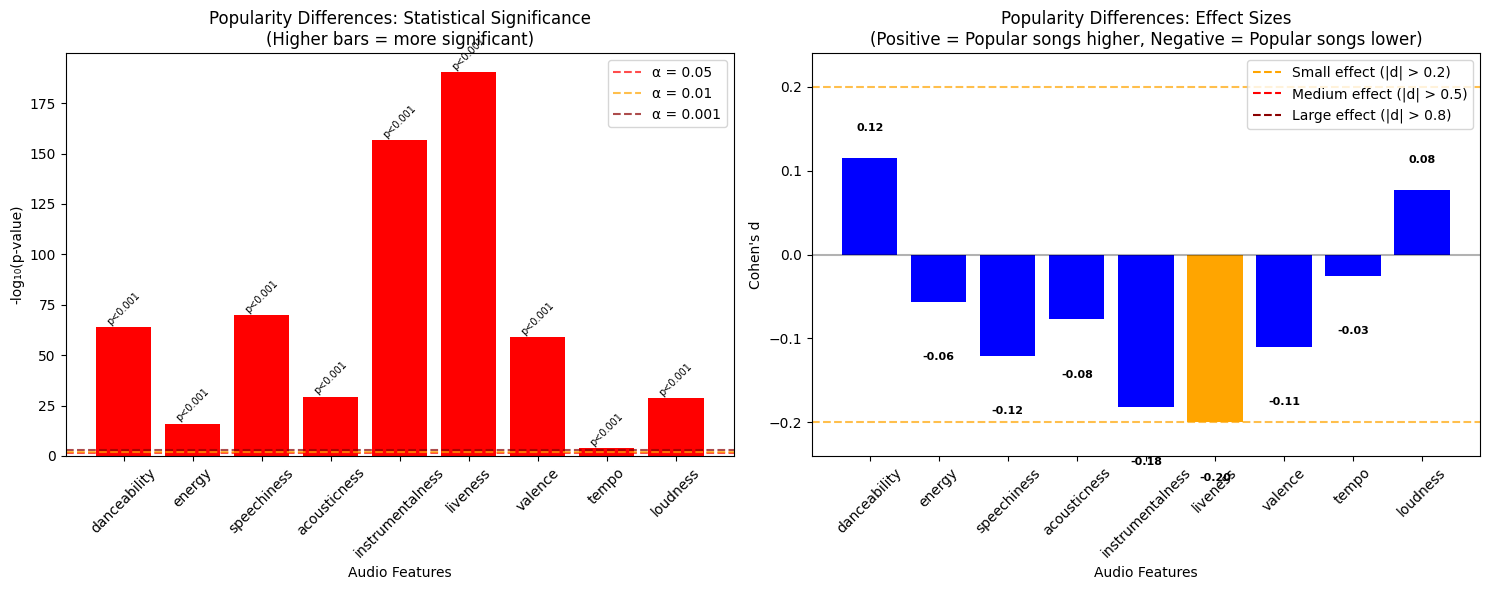


POPULARITY ANALYSIS SUMMARY
Features significantly different between popular/non-popular: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness']

Effect Size Interpretation:
  danceability   : Popular songs have negligible higher values ***
  energy         : Popular songs have negligible lower values ***
  speechiness    : Popular songs have negligible lower values ***
  acousticness   : Popular songs have negligible lower values ***
  instrumentalness: Popular songs have negligible lower values ***
  liveness       : Popular songs have small lower values ***
  valence        : Popular songs have negligible lower values ***
  tempo          : Popular songs have negligible lower values ***
  loudness       : Popular songs have negligible higher values ***


In [48]:
# Hypothesis Test 2: Popularity vs Audio Features
# H₀: Popular songs have the same audio characteristics as less popular songs
# H₁: Popular songs have different audio characteristics

# Create visualization with improved scaling for both plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: p-values (with logarithmic scale to show small p-values)
p_values = [popularity_results[feature]['p_value'] for feature in audio_features]
colors1 = ['red' if p < 0.05 else 'blue' for p in p_values]

# Use log scale for p-values
log_p_values = [-np.log10(p) if p > 0 else 10 for p in p_values]  # -log10 transformation
bars1 = ax1.bar(range(len(audio_features)), log_p_values, color=colors1)

# Add significance threshold lines
ax1.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='α = 0.05')
ax1.axhline(y=-np.log10(0.01), color='orange', linestyle='--', alpha=0.7, label='α = 0.01')
ax1.axhline(y=-np.log10(0.001), color='darkred', linestyle='--', alpha=0.7, label='α = 0.001')

ax1.set_xlabel('Audio Features')
ax1.set_ylabel('-log₁₀(p-value)')
ax1.set_title('Popularity Differences: Statistical Significance\n(Higher bars = more significant)')
ax1.set_xticks(range(len(audio_features)))
ax1.set_xticklabels(audio_features, rotation=45)
ax1.legend()

# Add p-value labels on bars
for i, (bar, p_val) in enumerate(zip(bars1, p_values)):
    height = bar.get_height()
    if p_val < 0.001:
        label = 'p<0.001'
    elif p_val < 0.01:
        label = f'p={p_val:.3f}'
    else:
        label = f'p={p_val:.3f}'
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             label, ha='center', va='bottom', fontsize=7, rotation=45)

# Plot 2: Effect sizes (improved with better scaling and labels)
effect_sizes = [popularity_results[feature]['cohens_d'] for feature in audio_features]
colors2 = ['red' if abs(d) > 0.5 else 'orange' if abs(d) > 0.2 else 'blue' for d in effect_sizes]
bars2 = ax2.bar(range(len(audio_features)), effect_sizes, color=colors2)

# Add effect size reference lines
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Small effect (+)')
ax2.axhline(y=-0.2, color='orange', linestyle='--', alpha=0.7, label='Small effect (-)')
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Medium effect (+)')
ax2.axhline(y=-0.5, color='red', linestyle='--', alpha=0.7, label='Medium effect (-)')
ax2.axhline(y=0.8, color='darkred', linestyle='--', alpha=0.7, label='Large effect (+)')
ax2.axhline(y=-0.8, color='darkred', linestyle='--', alpha=0.7, label='Large effect (-)')

ax2.set_xlabel('Audio Features')
ax2.set_ylabel("Cohen's d")
ax2.set_title('Popularity Differences: Effect Sizes\n(Positive = Popular songs higher, Negative = Popular songs lower)')
ax2.set_xticks(range(len(audio_features)))
ax2.set_xticklabels(audio_features, rotation=45)

# Create a custom legend for effect sizes
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='orange', linestyle='--', label='Small effect (|d| > 0.2)'),
    Line2D([0], [0], color='red', linestyle='--', label='Medium effect (|d| > 0.5)'),
    Line2D([0], [0], color='darkred', linestyle='--', label='Large effect (|d| > 0.8)')
]
ax2.legend(handles=legend_elements, loc='upper right')

# Add effect size labels on bars
for i, (bar, d_val) in enumerate(zip(bars2, effect_sizes)):
    height = bar.get_height()
    # Position label above or below bar depending on direction
    y_pos = height + (0.03 if height >= 0 else -0.06)
    va_pos = 'bottom' if height >= 0 else 'top'
    
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{d_val:.2f}', ha='center', va=va_pos, fontsize=8, fontweight='bold')

# Adjust y-axis limits for better visibility
max_effect = max([abs(d) for d in effect_sizes])
ax2.set_ylim(-max_effect * 1.2, max_effect * 1.2)

plt.tight_layout()
plt.savefig(f'{results_folder}/popularity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary of findings
print("\n" + "="*50)
print("POPULARITY ANALYSIS SUMMARY")
print("="*50)
print(f"Features significantly different between popular/non-popular: {significant_pop_features}")
print("\nEffect Size Interpretation:")
for feature in audio_features:
    d = popularity_results[feature]['cohens_d']
    p = popularity_results[feature]['p_value']
    direction = "higher" if d > 0 else "lower"
    magnitude = "large" if abs(d) > 0.8 else "medium" if abs(d) > 0.5 else "small" if abs(d) > 0.2 else "negligible"
    significance = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    
    if p < 0.05:
        print(f"  {feature:15}: Popular songs have {magnitude} {direction} values {significance}")


HYPOTHESIS TEST 3: AUDIO FEATURE CORRELATIONS
Correlation Matrix Calculated

Significant Correlations (p < 0.05):
--------------------------------------------------
danceability    vs energy         : r=0.134, p=0.000000 (weak positive)
danceability    vs speechiness    : r=0.109, p=0.000000 (weak positive)
danceability    vs acousticness   : r=-0.172, p=0.000000 (weak negative)
danceability    vs instrumentalness: r=-0.186, p=0.000000 (weak negative)
danceability    vs liveness       : r=-0.132, p=0.000000 (weak negative)
danceability    vs valence        : r=0.477, p=0.000000 (moderate positive)
danceability    vs tempo          : r=-0.050, p=0.000000 (weak negative)
danceability    vs loudness       : r=0.259, p=0.000000 (weak positive)
energy          vs speechiness    : r=0.143, p=0.000000 (weak positive)
energy          vs acousticness   : r=-0.734, p=0.000000 (strong negative)
energy          vs instrumentalness: r=-0.182, p=0.000000 (weak negative)
energy          vs liveness 

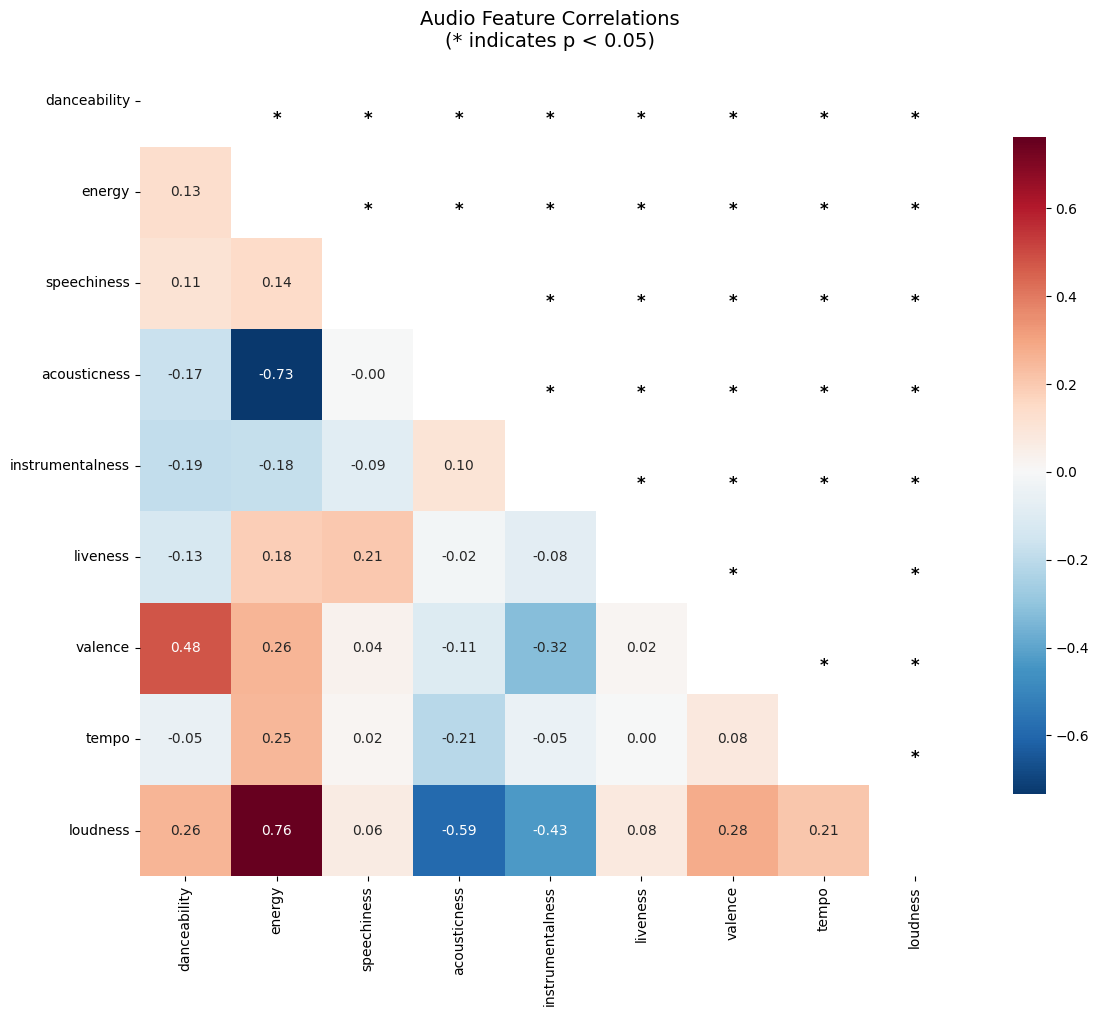


High correlations (|r| > 0.7) suggesting potential multicollinearity:
  energy ↔ acousticness: r = -0.734
  energy ↔ loudness: r = 0.762

Recommendation: Consider dimensionality reduction or feature selection for these pairs.


In [49]:
# Hypothesis Test 3: Audio Feature Correlations
# H₀: No significant correlation between audio features
# H₁: Significant correlations exist between audio features

print("\n" + "=" * 60)
print("HYPOTHESIS TEST 3: AUDIO FEATURE CORRELATIONS")
print("=" * 60)

# Calculate correlation matrix
correlation_matrix = test_df[audio_features].corr()
print("Correlation Matrix Calculated")

# Test significance of correlations
n = len(test_df)
correlation_tests = {}

print("\nSignificant Correlations (p < 0.05):")
print("-" * 50)

significant_correlations = []
for i, feature1 in enumerate(audio_features):
    for j, feature2 in enumerate(audio_features):
        if i < j:  # Avoid duplicates and self-correlation
            # Get correlation coefficient
            r = correlation_matrix.loc[feature1, feature2]
            
            # Calculate t-statistic for correlation significance
            t_stat = r * np.sqrt((n - 2) / (1 - r**2))
            p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))  # Two-tailed test
            
            correlation_tests[f"{feature1}_vs_{feature2}"] = {
                'correlation': r,
                'p_value': p_value,
                't_statistic': t_stat
            }
            
            if p_value < 0.05:
                strength = "very strong" if abs(r) > 0.8 else "strong" if abs(r) > 0.6 else "moderate" if abs(r) > 0.4 else "weak"
                direction = "positive" if r > 0 else "negative"
                significant_correlations.append((feature1, feature2, r, p_value))
                print(f"{feature1:15} vs {feature2:15}: r={r:.3f}, p={p_value:.6f} ({strength} {direction})")

print(f"\nFound {len(significant_correlations)} significant correlations out of {len(correlation_tests)} pairs tested")

# Bonferroni correction for multiple comparisons
bonferroni_alpha = 0.05 / len(correlation_tests)
print(f"Bonferroni corrected α = {bonferroni_alpha:.6f}")

bonferroni_significant = [corr for corr in significant_correlations if corr[3] < bonferroni_alpha]
print(f"Correlations significant after Bonferroni correction: {len(bonferroni_significant)}")

# Visualisation
plt.figure(figsize=(12, 10))

# Create correlation heatmap with significance markers
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create significance mask
significance_matrix = np.zeros_like(correlation_matrix)
for i, feature1 in enumerate(audio_features):
    for j, feature2 in enumerate(audio_features):
        if i != j:
            key = f"{feature1}_vs_{feature2}" if f"{feature1}_vs_{feature2}" in correlation_tests else f"{feature2}_vs_{feature1}"
            if key in correlation_tests:
                significance_matrix[i, j] = correlation_tests[key]['p_value']

# Plot heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})

# Add significance markers
for i in range(len(audio_features)):
    for j in range(len(audio_features)):
        if i < j and significance_matrix[i, j] < 0.05:
            plt.text(j + 0.5, i + 0.7, '*', ha='center', va='center', 
                    color='black', fontsize=12, fontweight='bold')

plt.title('Audio Feature Correlations\n(* indicates p < 0.05)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{results_folder}/correlation_significance.png', dpi=300, bbox_inches='tight')
plt.show()

# Implications for feature selection
high_correlations = [(f1, f2, r) for f1, f2, r, p in significant_correlations if abs(r) > 0.7]
print(f"\nHigh correlations (|r| > 0.7) suggesting potential multicollinearity:")
for f1, f2, r in high_correlations:
    print(f"  {f1} ↔ {f2}: r = {r:.3f}")

if high_correlations:
    print("\nRecommendation: Consider dimensionality reduction or feature selection for these pairs.")